In [1]:
# Cell 1: Importing Required Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Clustering imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

# Visualization imports
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Scikit-learn clustering modules loaded")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Scikit-learn clustering modules loaded


In [3]:
# Cell 2: Problem Introduction - Clustering Analysis
# Defining clustering objectives for particle physics data
# Approach: Unsupervised pattern discovery in collision events

print("="*70)
print("TASK D: CLUSTERING ANALYSIS")
print("="*70)

print("\nClustering Objectives:")
print("  1. Discover natural groupings in particle collision events")
print("  2. Identify event patterns beyond binary classification")
print("  3. Understand physics-based event characteristics")
print("  4. Validate clusters against known signal/background labels")

print("\nClustering Approaches:")
print("  - K-Means: Partition-based clustering")
print("  - Hierarchical: Agglomerative clustering")
print("  - DBSCAN: Density-based clustering")

print("\nWhy Clustering for HIGGS Data?")
print("  - Discover sub-categories within signal/background")
print("  - Identify rare event types")
print("  - Understand event topology patterns")
print("  - Validate supervised classification boundaries")

TASK D: CLUSTERING ANALYSIS

Clustering Objectives:
  1. Discover natural groupings in particle collision events
  2. Identify event patterns beyond binary classification
  3. Understand physics-based event characteristics
  4. Validate clusters against known signal/background labels

Clustering Approaches:
  - K-Means: Partition-based clustering
  - Hierarchical: Agglomerative clustering
  - DBSCAN: Density-based clustering

Why Clustering for HIGGS Data?
  - Discover sub-categories within signal/background
  - Identify rare event types
  - Understand event topology patterns
  - Validate supervised classification boundaries


In [6]:
# Cell 3: Loading and Preparing Data for Clustering
# Loading processed data, sampling, and SCALING features
# Feature scaling is critical for distance-based clustering

print("="*70)
print("DATA LOADING & PREPARATION FOR CLUSTERING")
print("="*70)

# Loading processed data
X_full, X_test_full, y_full, y_test_full = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nFull dataset loaded:")
print(f"  Training: {X_full.shape}")
print(f"  Test: {X_test_full.shape}")

# Sampling for computational efficiency
# Clustering on 800K samples is very slow - use representative sample
CLUSTER_SAMPLE_SIZE = 50000  # 50K samples for clustering

print(f"\nSampling {CLUSTER_SAMPLE_SIZE:,} events for clustering analysis")
print("   (Clustering is O(n²) - full dataset would take hours)")

# Stratified sampling to preserve class distribution
from sklearn.model_selection import train_test_split

X_cluster, _, y_cluster, _ = train_test_split(
    X_full, y_full,
    train_size=CLUSTER_SAMPLE_SIZE,
    random_state=SEED_VALUE,
    stratify=y_full
)

print(f"\nClustering Dataset (before scaling):")
print(f"  Shape: {X_cluster.shape}")
print(f"  Features: {X_cluster.shape[1]}")
print(f"  Samples: {X_cluster.shape[0]:,}")

# Feature Scaling for Clustering

print("\n" + "="*70)
print("FEATURE SCALING (CRITICAL FOR DISTANCE-BASED CLUSTERING)")
print("="*70)

print("\nWhy scaling is essential:")
print("  - K-Means uses Euclidean distance")
print("  - Hierarchical clustering uses distance metrics")
print("  - Features have different scales (pT vs angles)")
print("  - Unscaled → larger scale features dominate clustering")

# Storing original for comparison
X_cluster_original = X_cluster.copy()

# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Converting back to DataFrame to preserve column names
X_cluster = pd.DataFrame(
    X_cluster_scaled, 
    columns=X_cluster_original.columns,
    index=X_cluster_original.index
)

print("\nFeatures scaled using StandardScaler")
print(f"  Mean ≈ 0: {X_cluster.mean().mean():.6f}")
print(f"  Std ≈ 1: {X_cluster.std().mean():.4f}")

# Verify scaling
print("\nScaling verification (first 5 features):")
print(f"{'Feature':<30s} {'Original Mean':>15s} {'Scaled Mean':>15s} {'Scaled Std':>12s}")
print("-" * 75)
for col in X_cluster.columns[:5]:
    orig_mean = X_cluster_original[col].mean()
    scaled_mean = X_cluster[col].mean()
    scaled_std = X_cluster[col].std()
    print(f"{col:<30s} {orig_mean:>15.4f} {scaled_mean:>15.6f} {scaled_std:>12.4f}")


print(f"\nClass Distribution (for validation):")
print(f"  Signal (1): {(y_cluster == 1).sum():,} ({(y_cluster == 1).mean()*100:.1f}%)")
print(f"  Background (0): {(y_cluster == 0).sum():,} ({(y_cluster == 0).mean()*100:.1f}%)")

print("\nNote: True labels will be used only for cluster validation, not during clustering (unsupervised learning)")

DATA LOADING & PREPARATION FOR CLUSTERING
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Full dataset loaded:
  Training: (800000, 28)
  Test: (200000, 28)

Sampling 50,000 events for clustering analysis
   (Clustering is O(n²) - full dataset would take hours)

Clustering Dataset (before scaling):
  Shape: (50000, 28)
  Features: 28
  Samples: 50,000

FEATURE SCALING (CRITICAL FOR DISTANCE-BASED CLUSTERING)

Why scaling is essential:
  - K-Means uses Euclidean distance
  - Hierarchical clustering uses distance metrics
  - Features have different scales (pT vs angles)
  - Unscaled → larger scale features dominate clustering

Features scaled using StandardScaler
  Mean ≈ 0: 0.000000
  Std ≈ 1: 1.0000

Scaling verification (first 5 features):
Feature                          Original Mean     Scaled Mean   Scaled Std
---------------------------

DIMENSIONALITY REDUCTION (PCA)

Applying PCA for visualization...
   (PCA applied to SCALED features)

2D PCA:
  Explained variance: 21.60%
  PC1: 14.95%
  PC2: 6.66%

3D PCA:
  Explained variance: 28.00%
  PC1: 14.95%
  PC2: 6.66%
  PC3: 6.39%

Total variance captured by first 10 components:
   59.76%

PCA analysis saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\clustering_pca_analysis.png


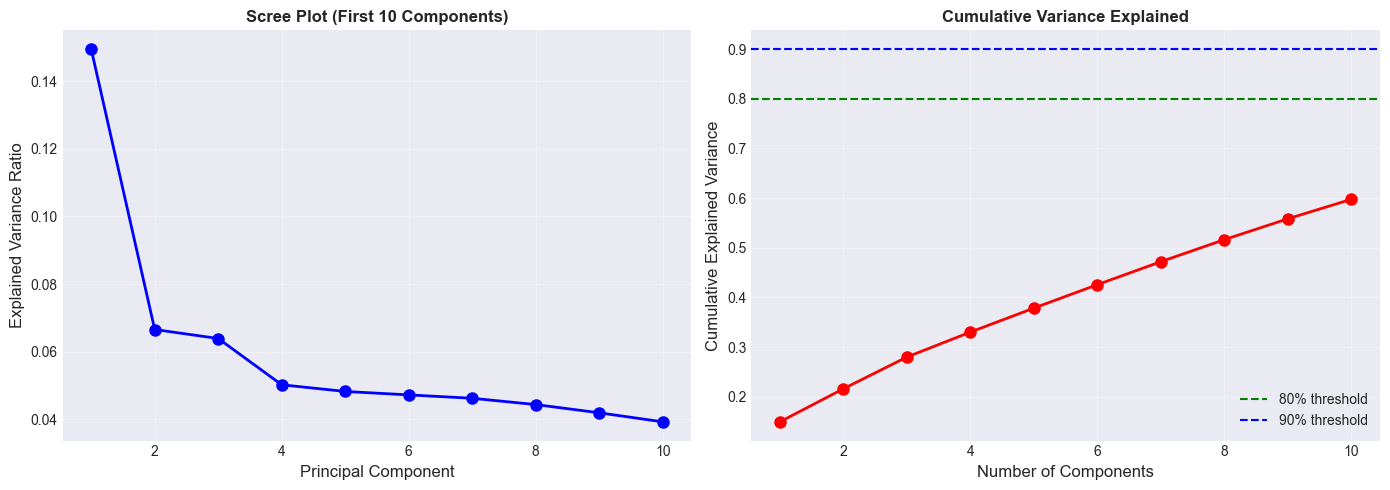

In [7]:
# Cell 4: Dimensionality Reduction - PCA
# Reducing to 2D/3D for visualization while preserving variance
# Using Principal Component Analysis (on SCALED data)

print("="*70)
print("DIMENSIONALITY REDUCTION (PCA)")
print("="*70)

# PCA for visualization (2D and 3D)
print("\nApplying PCA for visualization...")
print("   (PCA applied to SCALED features)")

# 2D PCA
pca_2d = PCA(n_components=2, random_state=SEED_VALUE)
X_pca_2d = pca_2d.fit_transform(X_cluster)

print(f"\n2D PCA:")
print(f"  Explained variance: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")

# 3D PCA
pca_3d = PCA(n_components=3, random_state=SEED_VALUE)
X_pca_3d = pca_3d.fit_transform(X_cluster)

print(f"\n3D PCA:")
print(f"  Explained variance: {pca_3d.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1: {pca_3d.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca_3d.explained_variance_ratio_[1]*100:.2f}%")
print(f"  PC3: {pca_3d.explained_variance_ratio_[2]*100:.2f}%")

# Full PCA for scree plot
pca_full = PCA(random_state=SEED_VALUE)
pca_full.fit(X_cluster)

print(f"\nTotal variance captured by first 10 components:")
print(f"   {pca_full.explained_variance_ratio_[:10].sum()*100:.2f}%")

# Visualize PCA variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, 11), pca_full.explained_variance_ratio_[:10], 
            'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (First 10 Components)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_[:10])
axes[1].plot(range(1, 11), cumulative_var, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='b', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

pca_path = FIGURE_OUTPUT / 'clustering_pca_analysis.png'
plt.savefig(pca_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nPCA analysis saved to {pca_path}")

plt.show()